# 5.5 Model Selection and Hyperparameter Tuning

This section will use the tools developed in the previous section to select between two prediction models, a problem known as **model selection**. Model selection encompasses many different kinds of questions:

- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$  in $k$ - nearest neighbors?
- Algorithm Selection: Is linear regression or $k$-nearest neighbors better for modeling our data?
- Feature Selection: Which set of features should we include in our model? (It is not always best to include all the features at our disposal.)

In the previous section, we saw how to use training and validation sets to estimate how well the model will perform on future data. Since one goal of machine learning is to build a model that will produce accurate predictions, a natural way to select a model is to choose the one that minimizes the validation error.

### Documentation

* pandas.Series.apply(): https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html

* Scikit-learn sklearn.compose.make_column_transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html
* Scikit-learn: preprocessing.OneHotEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* Scikit-learn: preprocessing.StandardScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* Scikit-learn  model_selection.cross_val_score: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
* Scikit-learn  sklearn.pipeline.make_pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html


In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.max_rows = 5

housing_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                      sep="\t")
housing_df

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0         1  526301100           20        RL         141.0     31770   Pave   
1         2  526350040           20        RH          80.0     11622   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
2928   2929  924100070           20        RL          77.0     10010   Pave   
2929   2930  924151050           60        RL          74.0      9627   Pave   

     Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0      NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1      NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
...    ...       ...          ...  ...       ...     ...    ...          ...   
2928   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
2929   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0           0       5    2010       WD           Normal     215000  
1           0       6    2010       WD           Normal     105000  
...       ...     ...     ...       ...             ...        ...  
2928        0       4    2006       WD           Normal     170000  
2929        0      11    2006       WD           Normal     188000  

[2930 rows x 82 columns]

# Hyperparameter Tuning

How do we choose $k$ in $k$-nearest neighbors? We can simply try all values of $k$ and pick the one with the smallest (test) MSE.

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath", "Bedroom AbvGr",
            "Year Built", "Yr Sold",
            "Neighborhood", "Bldg Type"]
X, y = housing_df[features], housing_df["SalePrice"]

X


Lot Area  Gr Liv Area  Full Bath  Half Bath  Bedroom AbvGr  Year Built  \
0        31770         1656          1          0              3        1960   
1        11622          896          1          0              2        1961   
...        ...          ...        ...        ...            ...         ...   
2928     10010         1389          1          0              2        1974   
2929      9627         2000          2          1              3        1993   

      Yr Sold Neighborhood Bldg Type  
0        2010        NAmes      1Fam  
1        2010        NAmes      1Fam  
...       ...          ...       ...  
2928     2006      Mitchel      1Fam  
2929     2006      Mitchel      1Fam  

[2930 rows x 9 columns]

In [19]:
X["Bldg Type"].unique()


array(['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'], dtype=object)

In [20]:
### enables us to call this function repeatedly with different values of k
def get_cv_error(k, X, y):
    # define pipeline
    encoder = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
         ["Neighborhood", "Bldg Type"]),
        remainder="passthrough"
    )
    scaler = StandardScaler()
    model = KNeighborsRegressor(n_neighbors=k)
    pipeline = make_pipeline(encoder, scaler, model)
    
    # calculate MSE
    mse = np.mean(-cross_val_score(
        pipeline, X, y, 
        cv=10, scoring="neg_mean_squared_error"
    ))
    return mse


In [22]:
    
ks = pd.Series(
    data=range(1, 31),
    index=range(1, 31)
)

ks

1      1
2      2
      ..
29    29
30    30
Length: 30, dtype: int64

4     1.359253e+09
3     1.377208e+09
          ...     
29    1.888804e+09
30    1.904666e+09
Length: 30, dtype: float64

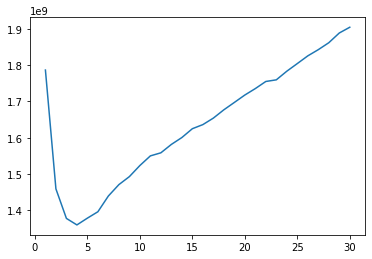

In [24]:

val_errs = ks.apply(lambda r: get_cv_error(r,X,y))   ### TRAINING!!!!

val_errs.plot.line()
val_errs.sort_values()

In [43]:
val_errs[:5]

1    1.786528e+09
2    1.458696e+09
3    1.377208e+09
4    1.359253e+09
5    1.377976e+09
dtype: float64

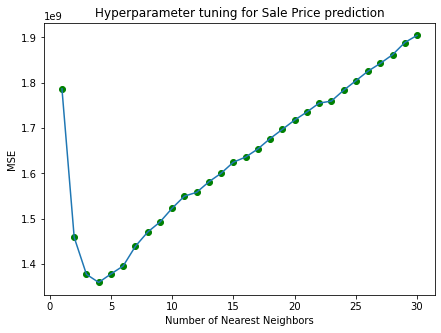

In [26]:
plt.figure(figsize=(7,5))
plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("MSE")
plt.title("Hyperparameter tuning for Sale Price prediction")
plt.scatter(x=val_errs.index, y=val_errs, c="green")
plt.plot(val_errs)
plt.show()


The MSE is minimized near $k = 4$, which suggests that a $4$-nearest neighbors model is optimal for prediction.

In [41]:
weightings=pd.Series(["uniform", "weighted"])

grid = pd.DataFrame(ks).merge(right=pd.DataFrame(weightings), how = "cross")


# Algorithm Selection

Is a $4$-nearest neighbors model better than linear regression? We already have an estimate of the the test error of the $4$-nearest neighbors model from above (it is in `val_errs`). We just need to calculate an estimate of the test error of the linear regression model. Let's set up the pipeline for linear regression:

In [50]:
from sklearn.linear_model import LinearRegression

encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
model = LinearRegression()
pipeline = make_pipeline(encoder, model)

linearErrors =  -cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error")


print("Linear regression   MSE: %.2f"% 
     linearErrors.mean())
print("4-nearest neighbors MSE: %.2f" % val_errs[4])

print("Difference:", linearErrors.mean() - val_errs[4])

Linear regression   MSE: 1353874914.53
4-nearest neighbors MSE: 1359252701.90
Difference: -5377787.368568659


In [53]:
amseLinear = linearErrors.mean()/len(X)
amseKNN = val_errs[4]/len(X)

amseLinear, amseKNN, amseLinear - amseKNN, np.sqrt(amseLinear), np.sqrt(amseKNN), np.sqrt(np.abs(amseLinear - amseKNN))




(462073.34966793074,
 463908.7719780225,
 -1835.4223100917297,
 679.7597734993817,
 681.1084876714006,
 42.84182897696747)

In [45]:
linearErrors

array([1.02585957e+09, 1.68811735e+09, 7.72841828e+08, 1.43601414e+09,
       1.10232834e+09, 2.15612215e+09, 1.25460480e+09, 2.13388854e+09,
       1.02501657e+09, 9.43955869e+08])

**FROM ALEX: THIS IS NOT THE CASE FOR THE DATA WE ARE WORKING WITH!**

$4$-nearest neighbors has a lower validation error, so there is no reason to consider the linear regression model any further.

# Model Selection

Suppose we are not sure whether `Yr Sold` should be included in the $4$-nearest neighbors model or not. To determine whether or not it should be included, we can fit a model with `Yr Sold` included and another model with it excluded, and see which model has the better (validation) MSE.

In [12]:
encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = make_pipeline(encoder, scaler, model)

In [56]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood", "Bldg Type"]
X, y = housing_df[features], housing_df["SalePrice"]

error1= -cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean()

error1

1353874914.5270371

In [57]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood", "Bldg Type"]
X, y = housing_df[features], housing_df["SalePrice"]

error2 = -cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean()
error2

1353628902.7174346

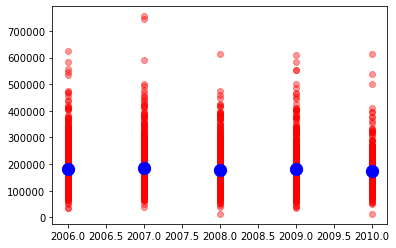

In [61]:
plt.figure()

plt.scatter(housing_df["Yr Sold"], housing_df["SalePrice"], alpha = 0.4, color="red", edgecolors="red")

f = housing_df.groupby("Yr Sold")["SalePrice"].mean()

plt.scatter(f.index, f, color = "blue", s=150)

plt.show()

The MSE actually goes down when we remove `Yr Sold`, so the model is actually better off without this variable.

Now, let's remove number of bedrooms

In [69]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath", 
            "Year Built",
            "Neighborhood", "Bldg Type"]
X, y = housing_df[features], housing_df["SalePrice"]

error3= -cross_val_score(pipeline, X, y, cv=10, scoring="neg_mean_squared_error").mean()

error3

1366211305.3891852

In [63]:
error3 - error2

53850720.52527094

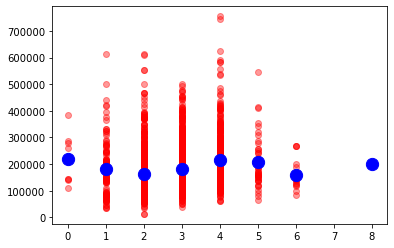

In [64]:
plt.figure()

plt.scatter(housing_df["Bedroom AbvGr"], housing_df["SalePrice"], alpha = 0.4, color="red", edgecolors="red")

f = housing_df.groupby("Bedroom AbvGr")["SalePrice"].mean()

plt.scatter(f.index, f, color = "blue", s=150)

plt.show()

# Fitting the Final Model

Now that we have determined the optimal model using cross validation, we need to actually fit  the model to be able to make predictions on future data. The key is to fit the model to _all_ of the current data---not just a fraction of the current data, as when we did cross validation. Since we already have an objective estimate of the test error of this model, we do not need to hold out any data for evaluation. We should use all of the data and build the best model that we can.

First, let's set up a pipeline that fits a $4$-nearest neighbor model to the set of features determined above (i.e., with `Yr Sold` removed).

In [65]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood", "Bldg Type"]

encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), 
     ["Neighborhood", "Bldg Type"]),
    remainder="passthrough"
)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = make_pipeline(encoder, scaler, model)

Now we are ready to fit the pipeline to the data using `pipeline.fit()`. Notice that we train the model on all of the current data.

In [71]:
X, y = housing_df[features], housing_df["SalePrice"]
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Neighborhood',
                                                   'Bldg Type'])])),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=4))])

To make predictions on future data, we can call `pipeline.predict()`. Keep in mind that the features must be formatted in exactly the same way as in the training data.

In [72]:
pipeline.predict(X)

array([174000., 137350., 166000., ..., 120250., 161625., 244725.])

### Exercise 1

Is `"Lot Area", "Gr Liv Area", "Full Bath", "Half Bath", "Bedroom AbvGr", "Year Built", "Neighborhood", "Bldg Type"` indeed the best set of features for predicting the `SalePrice` of a house for a K-nearest neighbors classifier for $k$ = 4?

Test 5 other sets of features to see if you can get a better cross-validation error.  Report your findings, and discuss them. Use whatever means necessary to visualize your results.


### Exercise 2

Suppose we want to understand whether Manhattan Distance, Eucledean Distance, or the following distance metric (let's call it *Chebyshev* distance):

$$ dist(x,y) = max_i(|x_i - y_i|)$$

is the best distance metric for predicting the sale price of a house based on a simplified set of attribtues: `"Lot Area", "Gr Liv Area", "Bedroom AbvGr"`

Construct a hyperparameter tuning process that finds the best pair of the distance metric and $k$ that optimizes the MSE.

Discuss your findings



Note, to use Chebyshev distance in training your KNN regression model, create the regression model as follows:


In [75]:
knnManhattan = KNeighborsRegressor(n_neighbors=4, p=1)  # manhattan
knnEuc = KNeighborsRegressor(n_neighbors=4, p=2)  # eucledean

knnChebyshev = KNeighborsRegressor(n_neighbors=4, metric="chebyshev")  # chebyshev

More on distances in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric

Submit:
   `handin dekhtyar 301-lab12 <file>`